In [2]:
import numpy as np
import pandas as pd
from ForestDiffusion import ForestDiffusionModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, f1_score
from openTSNE import TSNE
import matplotlib.pyplot as plt

In [14]:
import pandas as pd
data = pd.read_csv('diabetes.csv')
print(data.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [15]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

Class distribution before augmentation: {0: 500, 1: 268}


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train, y_train)
y_pred_orig = clf_orig.predict(X_test)
recall_orig = recall_score(y_test, y_pred_orig)
f1_orig = f1_score(y_test, y_pred_orig)

print(f"Recall score (original data): {recall_orig:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")

Recall score (original data): 0.5309
F1 score (original data): 0.5972


# ForestDiffusion

In [17]:
X_minority = X[y==1]
X_minority_np = X_minority.to_numpy()
forest_model = ForestDiffusionModel(X_minority_np, label_y=None, n_t=50, duplicate_K=100,
                                     bin_indexes=[], cat_indexes=[], int_indexes=[],
                                     diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X_minority))

In [18]:
#Save the generated samples
pd.DataFrame(X_minority_fake).to_csv('(breast_cancer)generated_minority_class (FD).csv', index=False)
print("Generated minority class data saved as (breast_cancer)generated_minority_class (FD).csv")

X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

print(X_balanced.shape)
print(y_balanced.shape)
print(len(X_minority_fake))

unique, counts = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique, counts))
print(f"Class distribution after augmentation: {class_dist_after}")

Generated minority class data saved as (breast_cancer)generated_minority_class (FD).csv
(1036, 8)
(1036,)
268
Class distribution after augmentation: {0.0: 500, 1.0: 536}


In [19]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)
y_pred_bal = clf_bal.predict(X_test)
recall_bal = recall_score(y_test, y_pred_bal)
f1_bal = f1_score(y_test, y_pred_bal)

print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")



Recall score (generated data): 0.8765
F1 score (generated data): 0.7760


c:\Users\Tawfique\Thesis\Llama3_8B\Llama-3.1-8B-Instruct\LlamaENVpip\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


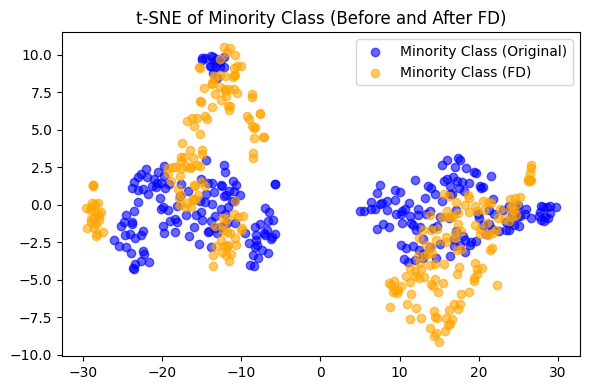

In [21]:
# Apply openTSNE for t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean",
    n_jobs=-1  # Use all available CPU cores for speedup
)


X_tsne_minority = tsne.fit(X_minority)
X_tsne_res_minority = tsne.fit(X_minority_fake)

# Create t-SNE Plot for minority class before and after SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for SMOTE-generated synthetic minority class data
ax.scatter(X_tsne_res_minority[:, 0], X_tsne_res_minority[:, 1], c='orange', label='Minority Class (FD)', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD)')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

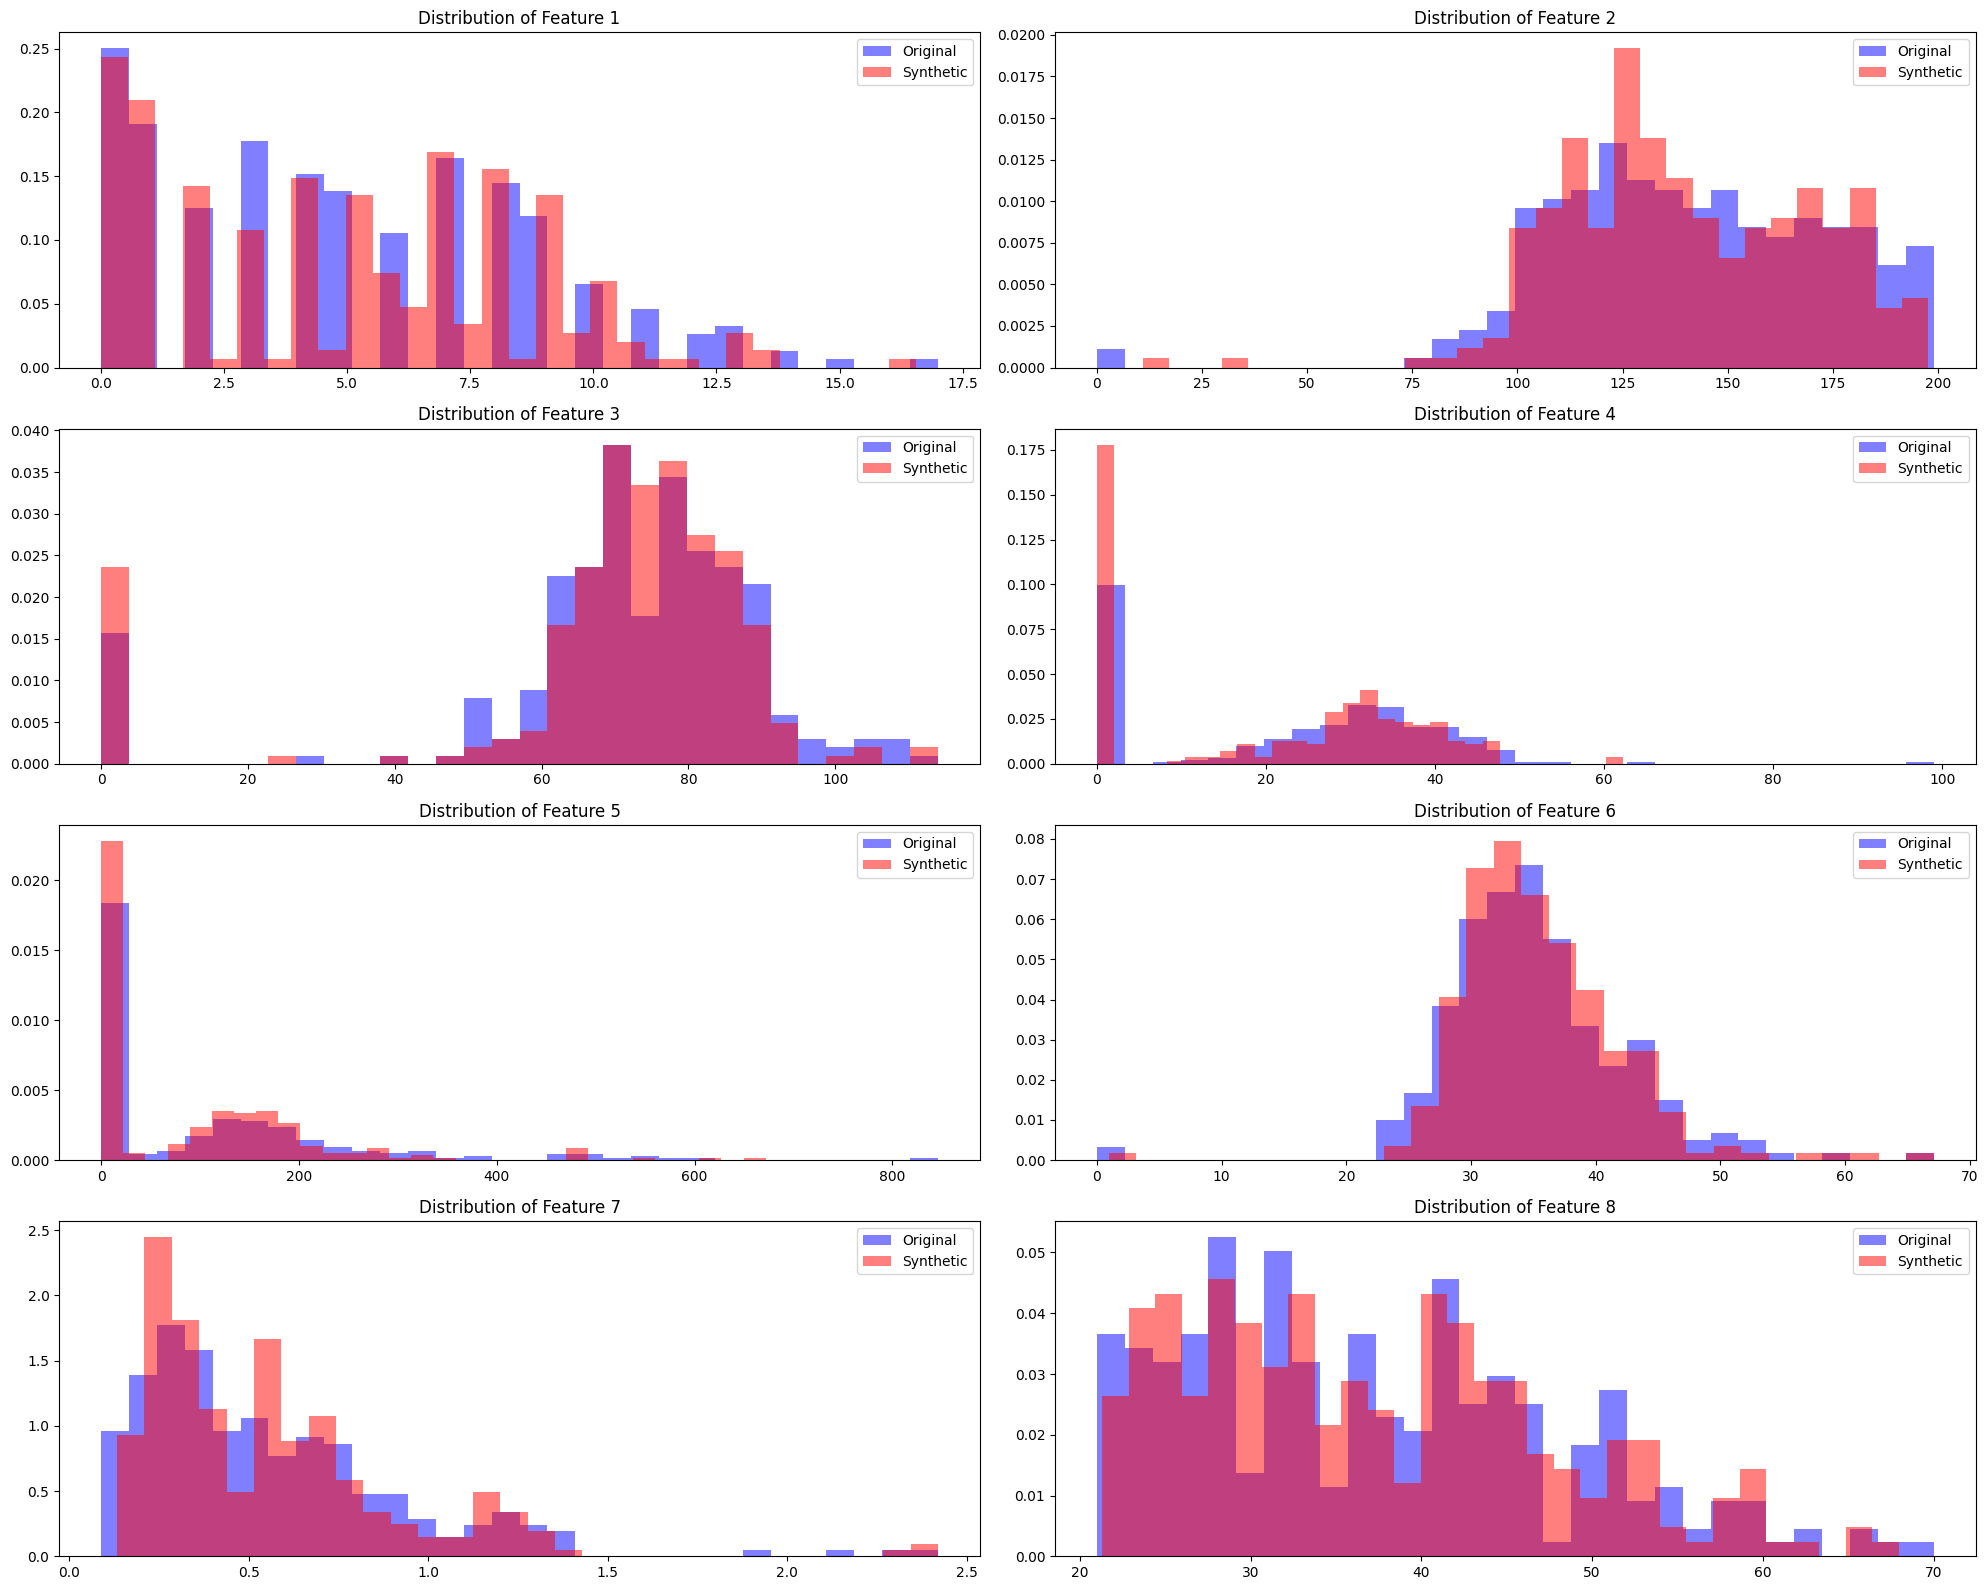

In [49]:
def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=30, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=30, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
X_minority_fake_df = pd.DataFrame(X_minority_fake)
plot_feature_distributions(X_minority, X_minority_fake_df)


# ForestDiffusion_CorrelationMatrix 

In [24]:
correlation_matrix = pd.DataFrame(X).corr()
print("Correlation Matrix of Original Data:")
print(correlation_matrix)

Correlation Matrix of Original Data:
                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.017683                 -0.033523   
Glucose                   0.331357  0.221071                  0.137337   
BloodPressu

In [8]:
X_minority = X[y==1]
X_minority_np = X_minority.to_numpy()
forest_model = ForestDiffusionModel(X_minority_np, label_y=None, n_t=50, duplicate_K=100,
                                     bin_indexes=[], cat_indexes=[], int_indexes=[],
                                     diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X_minority))

In [48]:
# Function to adjust the correlations of the generated data
def adjust_correlation(X, target_corr_matrix):
    
    # Calculate the Cholesky decomposition of the target correlation matrix
    L = np.linalg.cholesky(target_corr_matrix)
    
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # Transform the data to match the target correlation structure
    X_transformed = np.dot(X_centered, L.T)
    
    return X_transformed + np.mean(X, axis=0)

# Step 6: Adjust the synthetic data to match the original data's correlation matrix
X_minority_fake_adjusted = adjust_correlation(X_minority_fake, correlation_matrix)
min_original = np.min(X_minority, axis=0)  # Min of each feature
max_original = np.max(X_minority, axis=0)  # Max of each feature
pd.DataFrame(X_minority_fake_adjusted).to_csv('(diabetes)generated_minority_class (FD).csv', index=False)
# Perform min-max scaling for each feature
X_minority_fake_adjusted_1 = np.zeros_like(X_minority_fake_adjusted)  # Initialize scaled array

for i in range(X_minority_fake_adjusted.shape[1]):  # Iterate over each feature
    min_adj = np.min(X_minority_fake_adjusted_1[:, i])
    max_adj = np.max(X_minority_fake_adjusted_1[:, i])
    
    # Apply min-max scaling for each feature individually
    X_minority_fake_adjusted_1[:, i] = min_original[i] + (X_minority_fake_adjusted_1[:, i] - min_adj) * \
                                       (max_original[i] - min_original[i]) / (max_adj - min_adj)
    


pd.DataFrame(X_minority_fake_adjusted_1).to_csv('(diabetes)generated_minority_class_1 (FD).csv', index=False)

C:\Users\Tawfique\AppData\Local\Temp\ipykernel_29352\1694720747.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_minority_fake_adjusted_1[:, i] = min_original[i] + (X_minority_fake_adjusted_1[:, i] - min_adj) * \
C:\Users\Tawfique\AppData\Local\Temp\ipykernel_29352\1694720747.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (max_original[i] - min_original[i]) / (max_adj - min_adj)
C:\Users\Tawfique\AppData\Local\Temp\ipykernel_29352\1694720747.py:28: RuntimeWarning: invalid value encountered in divide
  X_minority_fake_adjusted_1[:, i] = min_original[i] + (X_minority_fake_adjusted_1[:, i] - min_adj) * \


In [10]:


pd.DataFrame(X_minority_fake_adjusted).to_csv('(breast_cancer) generated_minority_class_FD_CM.csv')

correlation_matrix_adjusted = pd.DataFrame(X_minority_fake_adjusted).corr()
print("Correlation Matrix of Synthetic Minority Data:")
print(correlation_matrix_adjusted)

X_balanced = np.concatenate((X, X_minority_fake_adjusted), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake_adjusted.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

Correlation Matrix of Synthetic Minority Data:
          0         1         2         3         4         5         6   \
0   1.000000  0.416520  0.998470  0.989105  0.962660 -0.957412  0.991515   
1   0.416520  1.000000  0.426313  0.432072  0.382252 -0.410445  0.441329   
2   0.998470  0.426313  1.000000  0.990582  0.974445 -0.953074  0.996185   
3   0.989105  0.432072  0.990582  1.000000  0.950279 -0.983054  0.995816   
4   0.962660  0.382252  0.974445  0.950279  1.000000 -0.878299  0.973968   
5  -0.957412 -0.410445 -0.953074 -0.983054 -0.878299  1.000000 -0.962250   
6   0.991515  0.441329  0.996185  0.995816  0.973968 -0.962250  1.000000   
7   0.992107  0.435106  0.997146  0.993267  0.979336 -0.955210  0.999629   
8   0.303370  0.150577  0.337444  0.235562  0.522749 -0.054031  0.323106   
9   0.990038  0.435320  0.994685  0.997045  0.970764 -0.966484  0.999773   
10  0.988533  0.433914  0.990339  0.999980  0.950912 -0.982666  0.996024   
11  0.987184  0.456351  0.989437  0.99956

In [11]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")

Recall score (original data): 0.9062
Recall score (generated data): 0.9531
F1 score (original data): 0.9508
F1 score (generated data): 0.9760


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


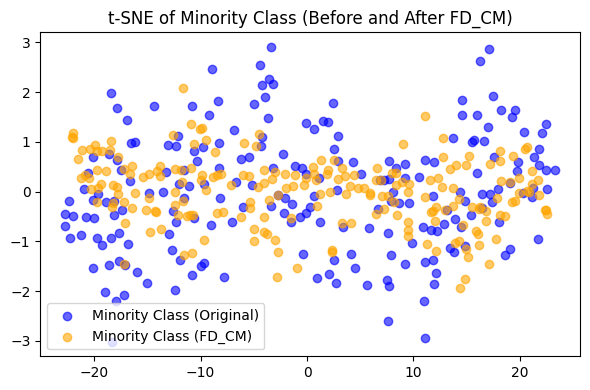

In [12]:
# Apply openTSNE for t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean",
    n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority)
X_tsne_res_minority = tsne.fit(X_minority_fake_adjusted)

# Create t-SNE Plot for minority class before and after SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for SMOTE-generated synthetic minority class data
ax.scatter(X_tsne_res_minority[:, 0], X_tsne_res_minority[:, 1], c='orange', label='Minority Class (FD_CM)', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD_CM)')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


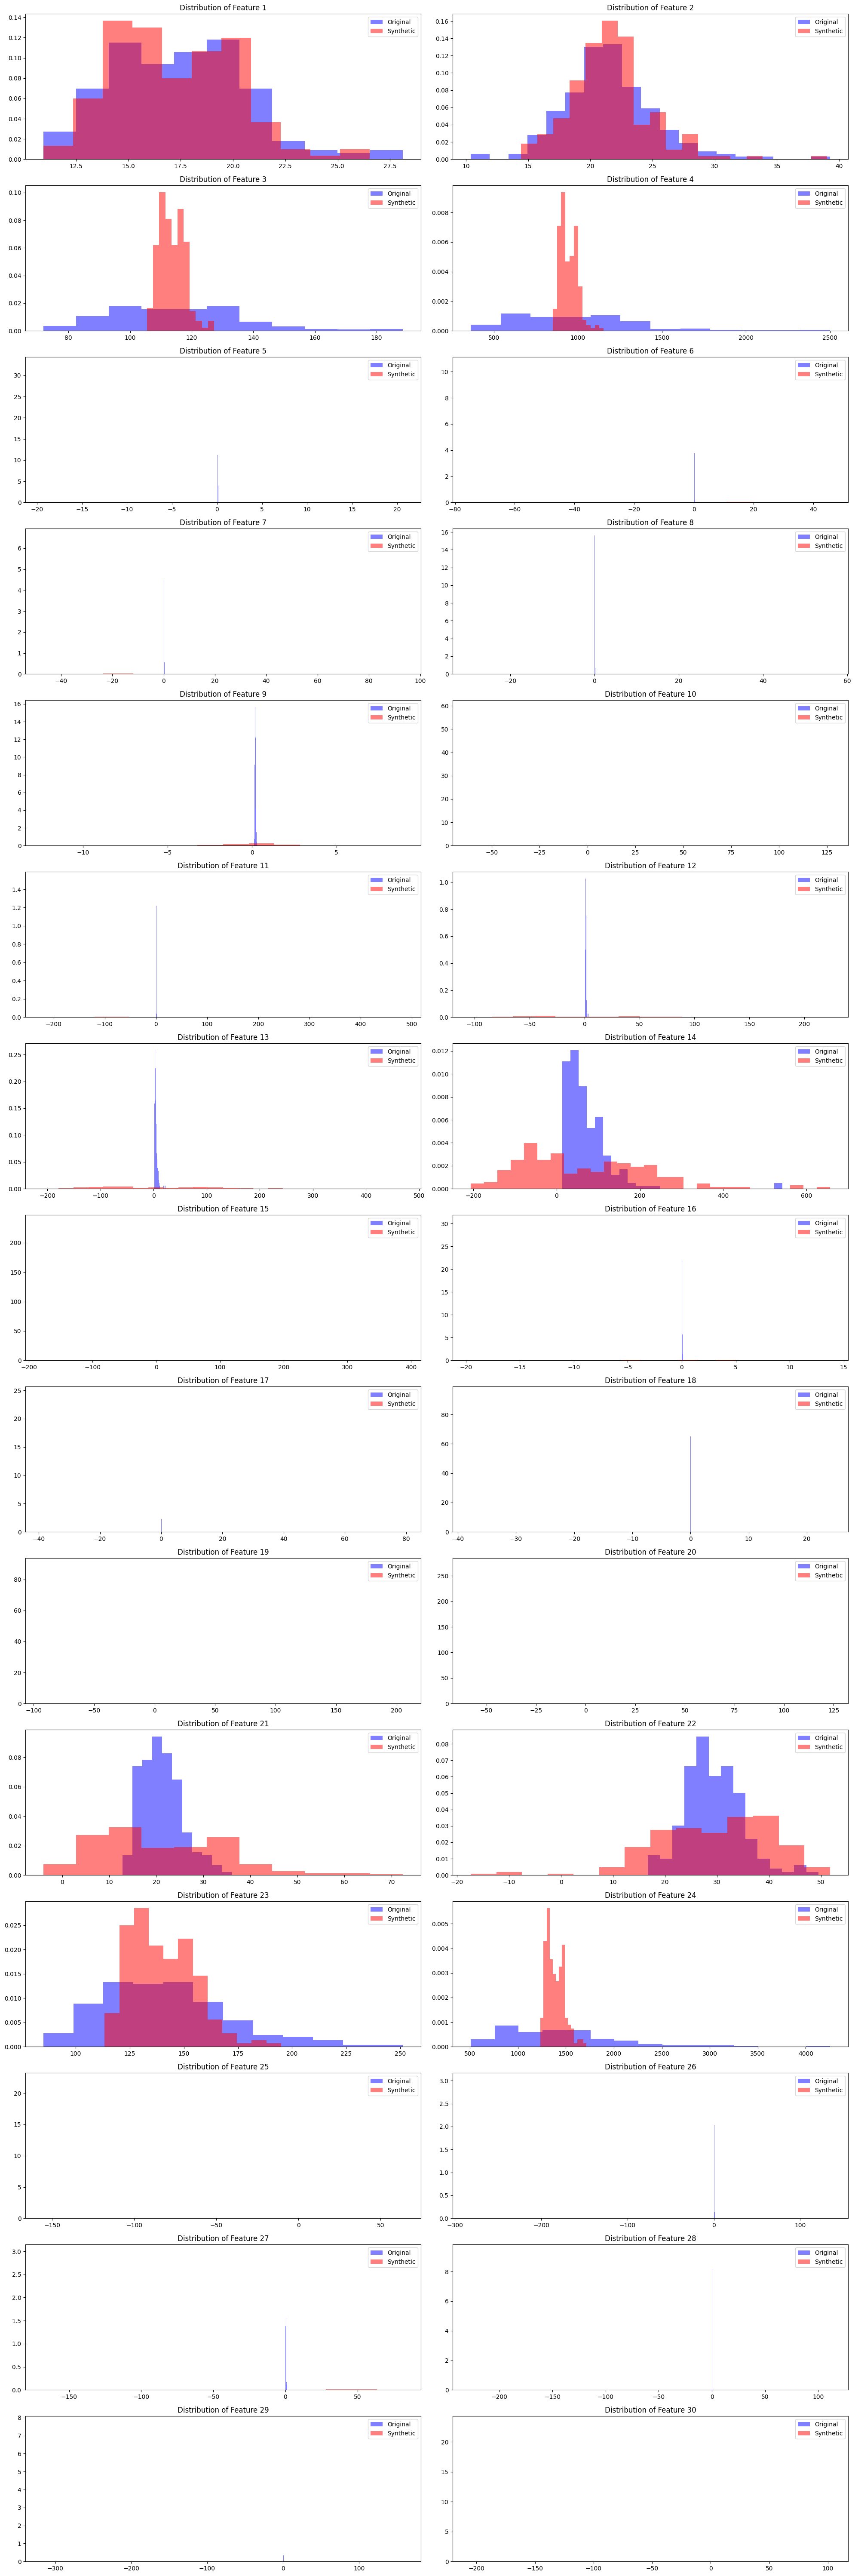

In [13]:
def freedman_diaconis_bins(data):
    # Calculate IQR
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    
    # Calculate bin width using Freedman-Diaconis rule
    bin_width = 2 * iqr / (len(data) ** (1/3))
    
    # Calculate number of bins
    num_bins = int((data.max() - data.min()) / bin_width)
    
    return max(1, num_bins)  # Ensure at least 1 bin

def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Dynamically calculate number of bins for this feature
        num_bins = freedman_diaconis_bins(original_data.iloc[:, i])
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
    
X_minority_df = pd.DataFrame(X_minority)
X_minority_fake_df = pd.DataFrame(X_minority_fake_adjusted)
plot_feature_distributions(X_minority_df, X_minority_fake_df)

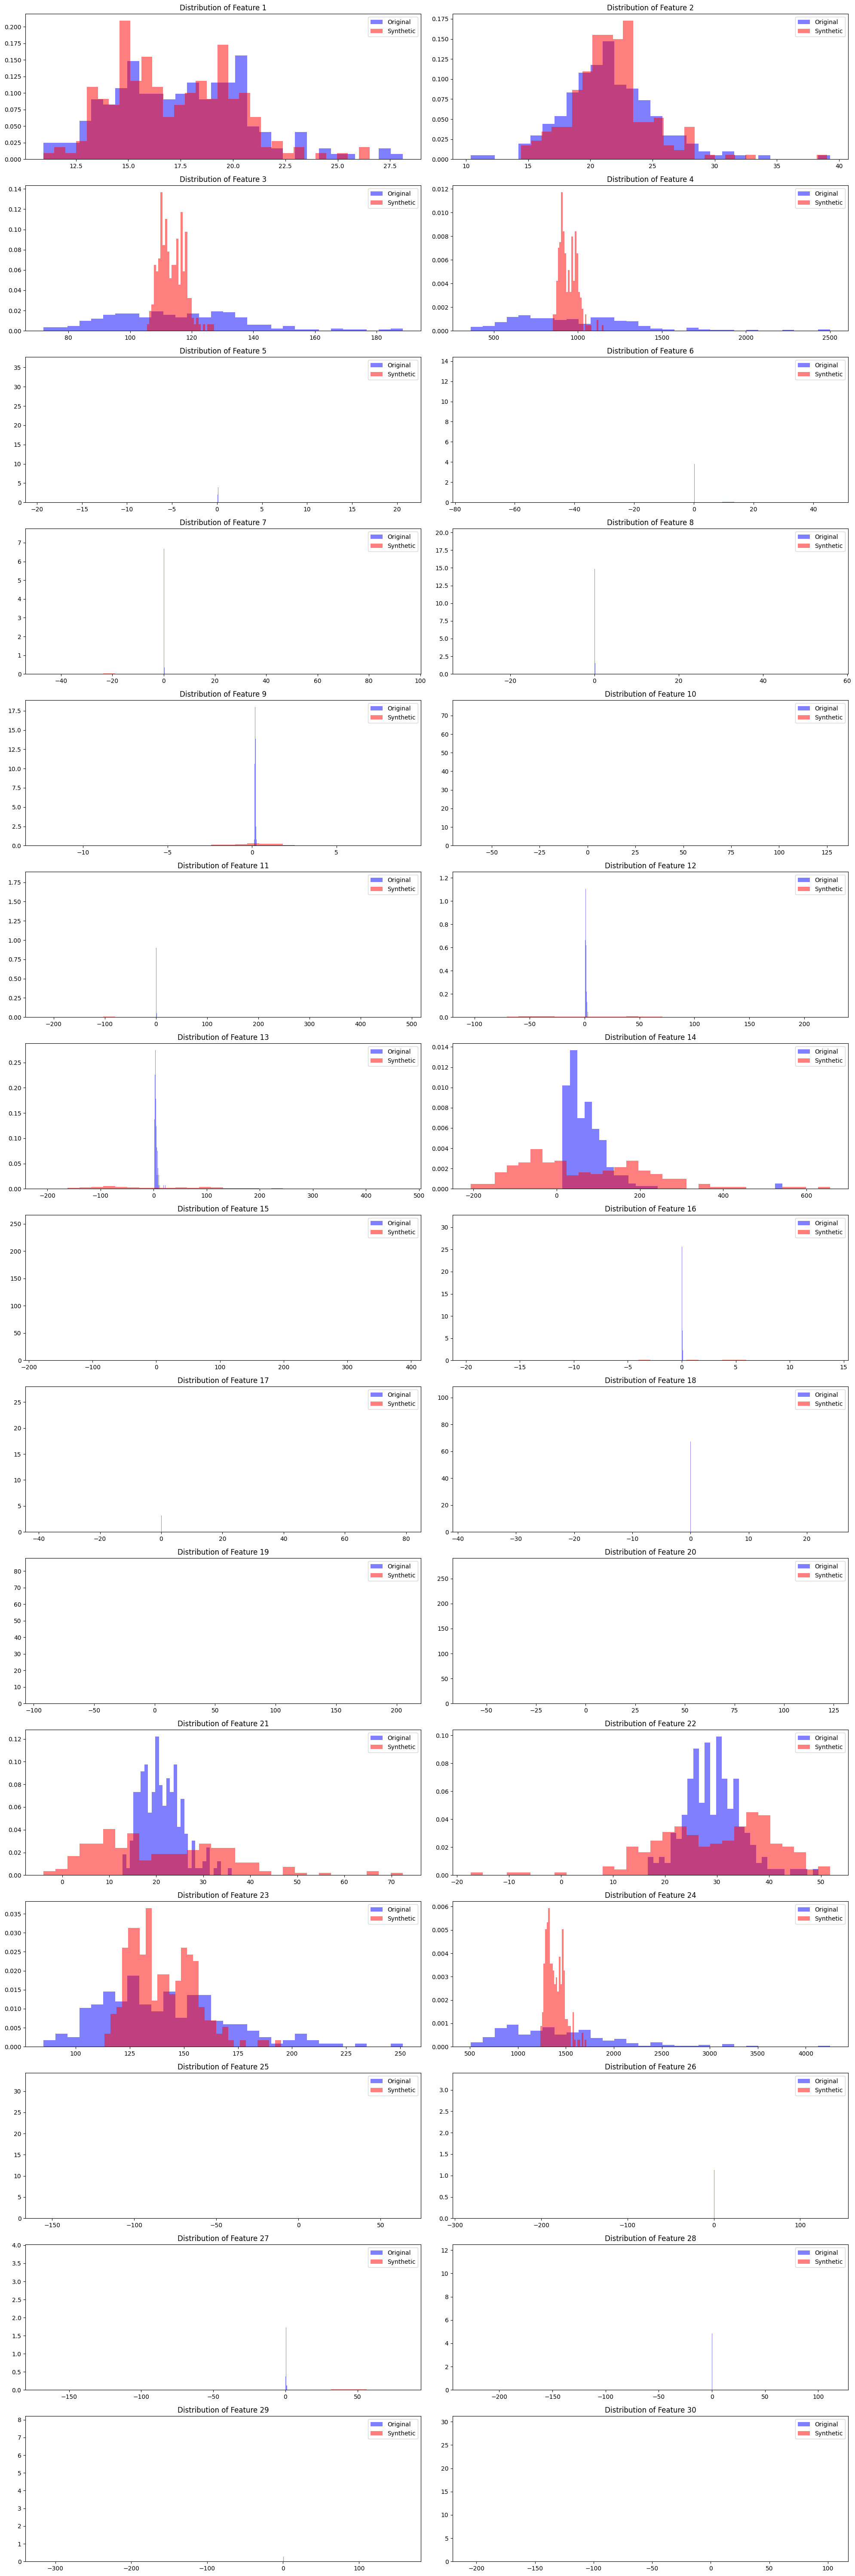

In [18]:
def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=30, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=30, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
X_minority_df = pd.DataFrame(X_minority)
X_minority_fake_df = pd.DataFrame(X_minority_fake_adjusted)
plot_feature_distributions(X_minority_df, X_minority_fake_df)

# ForestDiffusion_CM(Minority)

In [15]:
correlation_matrix_minority = pd.DataFrame(X_minority).corr()
print("Correlation Matrix of Original Minority Data:")
print(correlation_matrix_minority)

Correlation Matrix of Original Minority Data:
                         radius_mean  texture_mean  perimeter_mean  area_mean  \
radius_mean                 1.000000      0.106516        0.995281   0.990078   
texture_mean                0.106516      1.000000        0.110682   0.103729   
perimeter_mean              0.995281      0.110682        1.000000   0.987223   
area_mean                   0.990078      0.103729        0.987223   1.000000   
smoothness_mean            -0.116036     -0.143920       -0.052401  -0.088281   
compactness_mean            0.169168      0.032567        0.256409   0.170181   
concavity_mean              0.482750      0.067135        0.554994   0.493151   
concave points_mean         0.675519      0.017453        0.730158   0.677513   
symmetry_mean              -0.076442     -0.090009       -0.014329  -0.080828   
fractal_dimension_mean     -0.388679     -0.061559       -0.313563  -0.368612   
radius_se                   0.639270      0.038681        0.654

In [16]:
# Function to adjust the correlations of the generated data
def adjust_correlation(X, target_corr_matrix):
    
    # Calculate the Cholesky decomposition of the target correlation matrix
    L = np.linalg.cholesky(target_corr_matrix)
    
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # Transform the data to match the target correlation structure
    X_transformed = np.dot(X_centered, L.T)
    
    return X_transformed + np.mean(X, axis=0)

# Step 6: Adjust the synthetic data to match the original data's correlation matrix
X_minority_fake_adjusted = adjust_correlation(X_minority_fake, correlation_matrix_minority)

In [19]:

pd.DataFrame(X_minority_fake_adjusted).to_csv('(breast_cancer) generated_minority_class_FD_CM(minority).csv')

correlation_matrix_adjusted = pd.DataFrame(X_minority_fake_adjusted).corr()
print("Correlation Matrix of Synthetic Minority Data:")
print(correlation_matrix_adjusted)

X_balanced = np.concatenate((X, X_minority_fake_adjusted), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake_adjusted.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

Correlation Matrix of Synthetic Minority Data:
          0         1         2         3         4         5         6   \
0   1.000000  0.234787  0.997469  0.989269  0.990389 -0.945788  0.988056   
1   0.234787  1.000000  0.245174  0.253403  0.245569 -0.244353  0.253491   
2   0.997469  0.245174  1.000000  0.990545  0.994289 -0.937221  0.996466   
3   0.989269  0.253403  0.990545  1.000000  0.998749 -0.973605  0.987444   
4   0.990389  0.245569  0.994289  0.998749  1.000000 -0.961447  0.993833   
5  -0.945788 -0.244353 -0.937221 -0.973605 -0.961447  1.000000 -0.925358   
6   0.988056  0.253491  0.996466  0.987444  0.993833 -0.925358  1.000000   
7   0.966412  0.217634  0.979923  0.951571  0.965156 -0.856611  0.987811   
8  -0.977616 -0.261807 -0.975166 -0.995722 -0.990014  0.990379 -0.968772   
9   0.986626  0.250225  0.995433  0.989198  0.995187 -0.930097  0.999742   
10  0.988533  0.253607  0.990205  0.999979  0.998845 -0.973370  0.987613   
11  0.977668  0.377147  0.985566  0.98570

In [20]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")

Recall score (original data): 0.9062
Recall score (generated data): 0.9531
F1 score (original data): 0.9508
F1 score (generated data): 0.9760


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


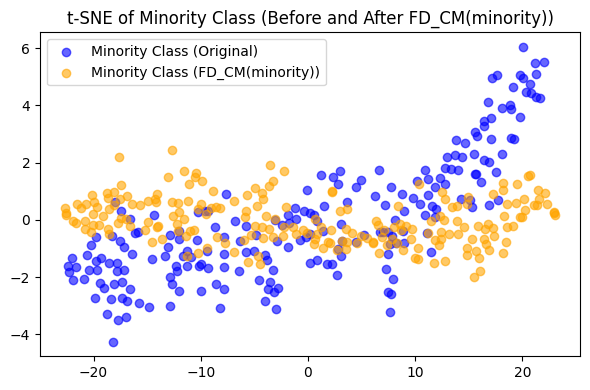

In [21]:
# Apply openTSNE for t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean",
    n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority)
X_tsne_res_minority = tsne.fit(X_minority_fake_adjusted)

# Create t-SNE Plot for minority class before and after SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for SMOTE-generated synthetic minority class data
ax.scatter(X_tsne_res_minority[:, 0], X_tsne_res_minority[:, 1], c='orange', label='Minority Class (FD_CM(minority))', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD_CM(minority))')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


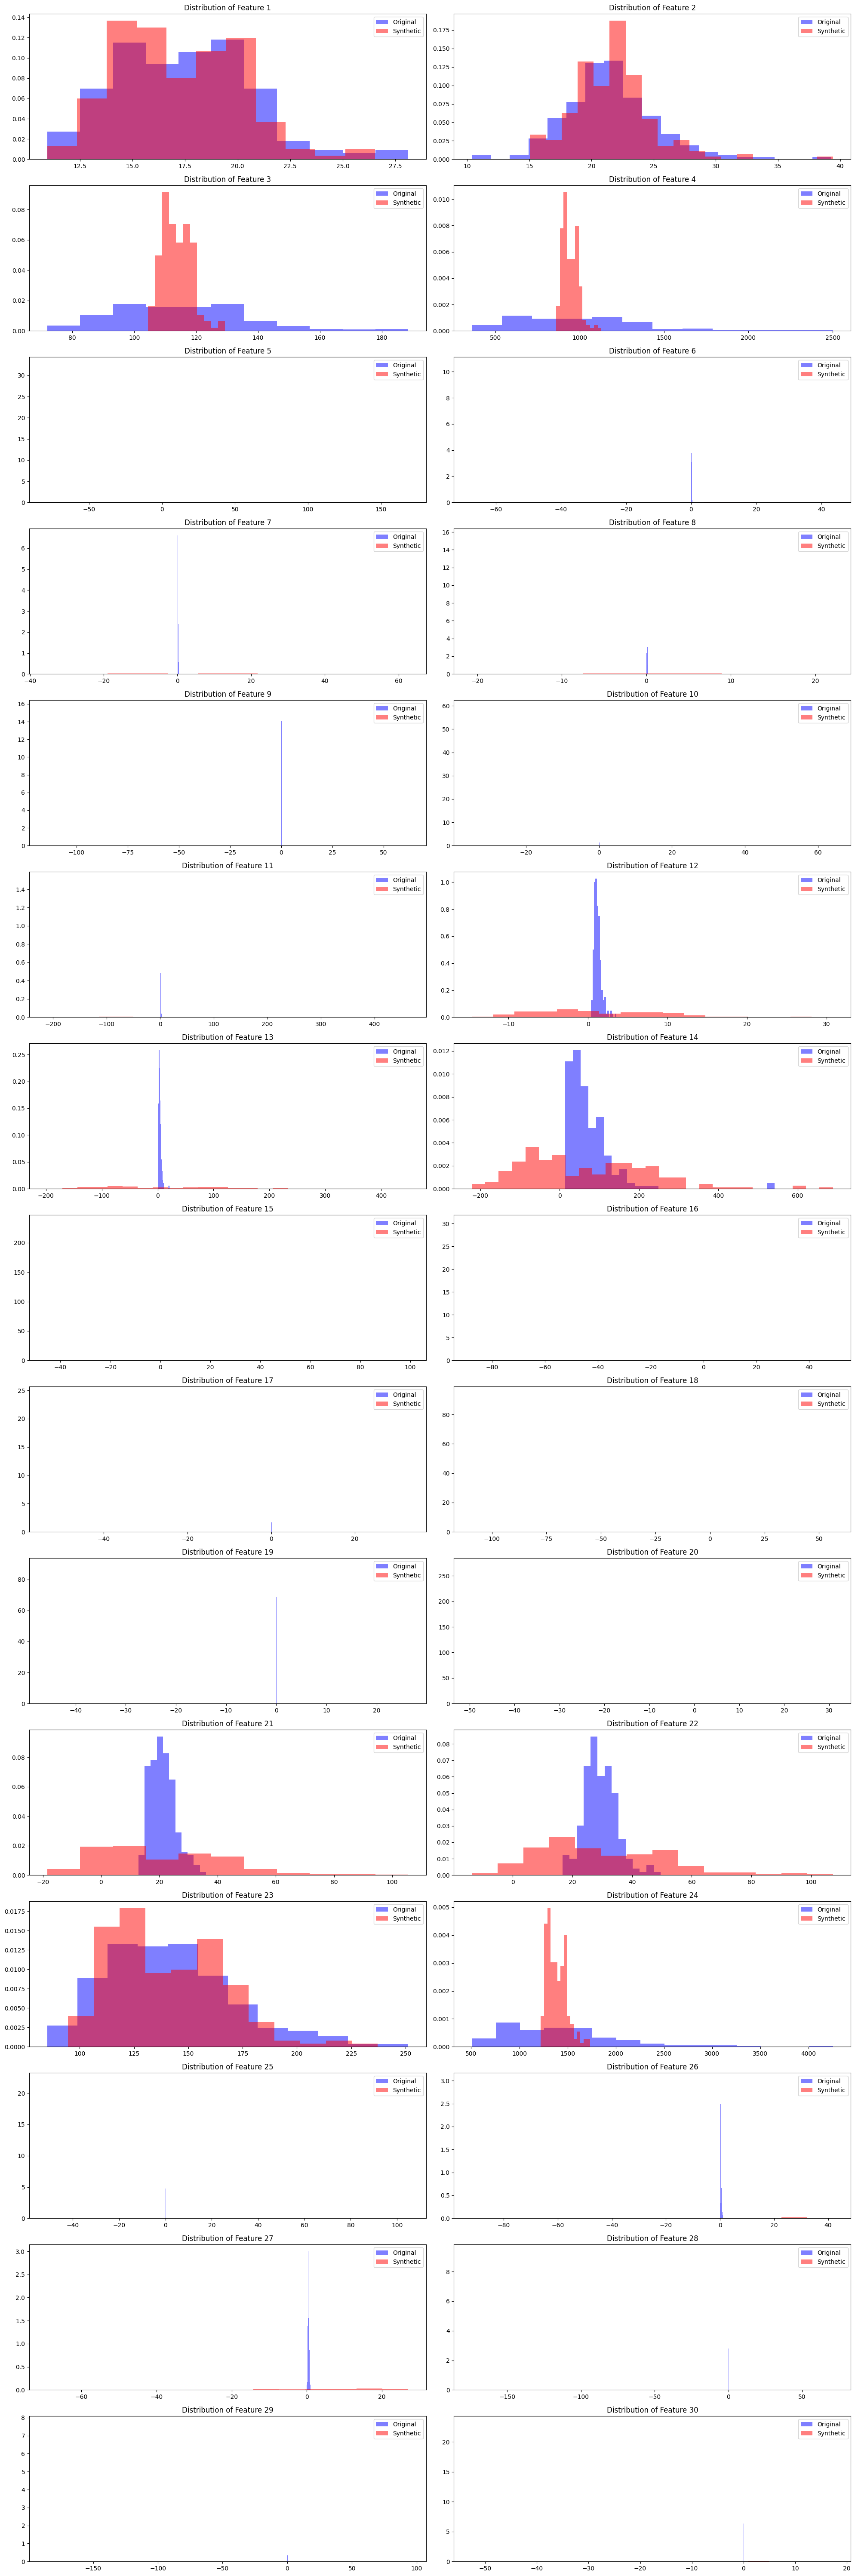

In [22]:
def freedman_diaconis_bins(data):
    # Calculate IQR
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    
    # Calculate bin width using Freedman-Diaconis rule
    bin_width = 2 * iqr / (len(data) ** (1/3))
    
    # Calculate number of bins
    num_bins = int((data.max() - data.min()) / bin_width)
    
    return max(1, num_bins)  # Ensure at least 1 bin

def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Dynamically calculate number of bins for this feature
        num_bins = freedman_diaconis_bins(original_data.iloc[:, i])
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
    
X_minority_df = pd.DataFrame(X_minority)
X_minority_fake_df = pd.DataFrame(X_minority_fake_adjusted)
plot_feature_distributions(X_minority_df, X_minority_fake_df)

# Correlation adjustment (minority class) using Cholesky Decomposition and Min_Max Scaling

In [ ]:
X_minority = X[y==1]
X_minority_np = X_minority.to_numpy()
forest_model = ForestDiffusionModel(X_minority_np, label_y=None, n_t=50, duplicate_K=100,
                                     bin_indexes=[], cat_indexes=[], int_indexes=[],
                                     diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X_minority))

In [26]:
print(np.isnan(X_minority).sum(), np.isinf(X_minority).sum())
print(np.isnan(X_minority_fake).sum(), np.isinf(X_minority_fake).sum())


radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64 radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
s

In [36]:
import numpy as np

# Step 1: Compute the covariance matrices
cov_minority = np.cov(X_minority, rowvar=False)
cov_minority_fake = np.cov(X_minority_fake, rowvar=False)

# Step 2: Cholesky decomposition
# Ensure the covariance matrices are positive definite
epsilon = 1e-5
cov_minority += np.eye(cov_minority.shape[0]) * epsilon
cov_minority_fake += np.eye(cov_minority_fake.shape[0]) * epsilon

# Perform Cholesky decomposition on the original covariance matrix
L_minority = np.linalg.cholesky(cov_minority)

# Step 3: Standardize synthetic data
synthetic_mean = np.mean(X_minority_fake, axis=0)
synthetic_std = np.std(X_minority_fake, axis=0)
standardized_synthetic = (X_minority_fake - synthetic_mean) / synthetic_std

# Adjust the synthetic data to match the correlation of the original minority class
adjusted_synthetic = (L_minority @ standardized_synthetic.T).T

# Rescale the adjusted synthetic data
adjusted_synthetic = adjusted_synthetic * synthetic_std + synthetic_mean

# Step 4: Min-Max scaling to fit within the range of X_minority
min_original = np.min(X_minority, axis=0)  # Min of each feature
max_original = np.max(X_minority, axis=0)  # Max of each feature

# Perform min-max scaling for each feature
X_minority_fake_adjusted = np.zeros_like(adjusted_synthetic)  # Initialize scaled array

for i in range(adjusted_synthetic.shape[1]):  # Iterate over each feature
    min_adj = np.min(adjusted_synthetic[:, i])
    max_adj = np.max(adjusted_synthetic[:, i])
    
    # Apply min-max scaling for each feature individually
    X_minority_fake_adjusted[:, i] = min_original[i] + (adjusted_synthetic[:, i] - min_adj) * \
                                       (max_original[i] - min_original[i]) / (max_adj - min_adj)
    
    

print("Original Minority Correlation:\n", np.corrcoef(X_minority, rowvar=False))
print("Adjusted Synthetic Correlation:\n", np.corrcoef(X_minority_fake_adjusted, rowvar=False))
print("Adjusted Synthetic Data (after min-max scaling):\n", X_minority_fake_adjusted)

pd.DataFrame(X_minority_fake_adjusted).to_csv('breast_cancer_generated_minority_FD_CM(minority).csv')


Original Minority Correlation:
 [[ 1.          0.10651642  0.99528148  0.99007845 -0.11603615  0.16916808
   0.48275037  0.67551912 -0.0764423  -0.38867852  0.63926965  0.04687304
   0.62478537  0.69235898  0.0280374   0.07825081  0.1975707   0.23470949
   0.03372713 -0.03676151  0.9216533  -0.0888897   0.91487709  0.89393498
  -0.32664876 -0.11482397  0.06962069  0.38346081 -0.2663755  -0.3833671 ]
 [ 0.10651642  1.          0.11068243  0.1037292  -0.1439199   0.03256663
   0.06713524  0.01745292 -0.09000937 -0.06155935  0.03868087  0.3059498
   0.06022313  0.04852184  0.0425109   0.1274106   0.11011109  0.04092971
  -0.06061514  0.06556228  0.1260224   0.84683148  0.13660507  0.12669777
  -0.02401332  0.10407967  0.11007509 -0.0022133  -0.08738607  0.02596004]
 [ 0.99528148  0.11068243  1.          0.98722278 -0.05240067  0.25640866
   0.554994    0.73015831 -0.01432876 -0.31356336  0.65408346  0.06834889
   0.65134605  0.70473557  0.05187314  0.14404185  0.25744873  0.27601241
   0.

/tmp/ipykernel_30/3281593487.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_minority_fake_adjusted[:, i] = min_original[i] + (adjusted_synthetic[:, i] - min_adj) * \
/tmp/ipykernel_30/3281593487.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (max_original[i] - min_original[i]) / (max_adj - min_adj)


In [37]:
correlation_matrix_adjusted = pd.DataFrame(X_minority_fake_adjusted).corr()
print("Correlation Matrix of Synthetic Minority Data:")
print(correlation_matrix_adjusted)

X_balanced = np.concatenate((X, X_minority_fake_adjusted), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake_adjusted.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

Correlation Matrix of Synthetic Minority Data:
          0         1         2         3         4         5         6   \
0   1.000000  0.243489  0.999859  0.999800  0.515991  0.870231  0.893669   
1   0.243489  1.000000  0.249358  0.245051 -0.020569  0.259450  0.252405   
2   0.999859  0.249358  1.000000  0.999814  0.523267  0.876243  0.898804   
3   0.999800  0.245051  0.999814  1.000000  0.519576  0.872408  0.895748   
4   0.515991 -0.020569  0.523267  0.519576  1.000000  0.812694  0.809933   
5   0.870231  0.259450  0.876243  0.872408  0.812694  1.000000  0.993857   
6   0.893669  0.252405  0.898804  0.895748  0.809933  0.993857  1.000000   
7   0.895603  0.191419  0.900062  0.897474  0.825209  0.987853  0.996365   
8   0.364680  0.057328  0.373338  0.366728  0.853665  0.737952  0.703235   
9   0.183267  0.087200  0.193920  0.187951  0.851009  0.631708  0.587912   
10  0.931129  0.245463  0.934262  0.933532  0.642887  0.911366  0.926171   
11  0.308879  0.575953  0.316887  0.31246

In [39]:
pd.DataFrame(X_minority_fake_adjusted).to_csv('temp.csv')

In [38]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")

Recall score (original data): 0.9062
Recall score (generated data): 0.9375
F1 score (original data): 0.9508
F1 score (generated data): 0.9677


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


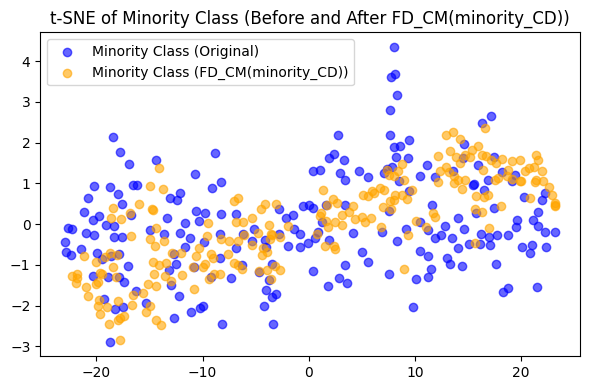

In [40]:
# Apply openTSNE for t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean",
    n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority)
X_tsne_res_minority = tsne.fit(X_minority_fake_adjusted)

# Create t-SNE Plot for minority class before and after SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for SMOTE-generated synthetic minority class data
ax.scatter(X_tsne_res_minority[:, 0], X_tsne_res_minority[:, 1], c='orange', label='Minority Class (FD_CM(minority_CD))', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD_CM(minority_CD))')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


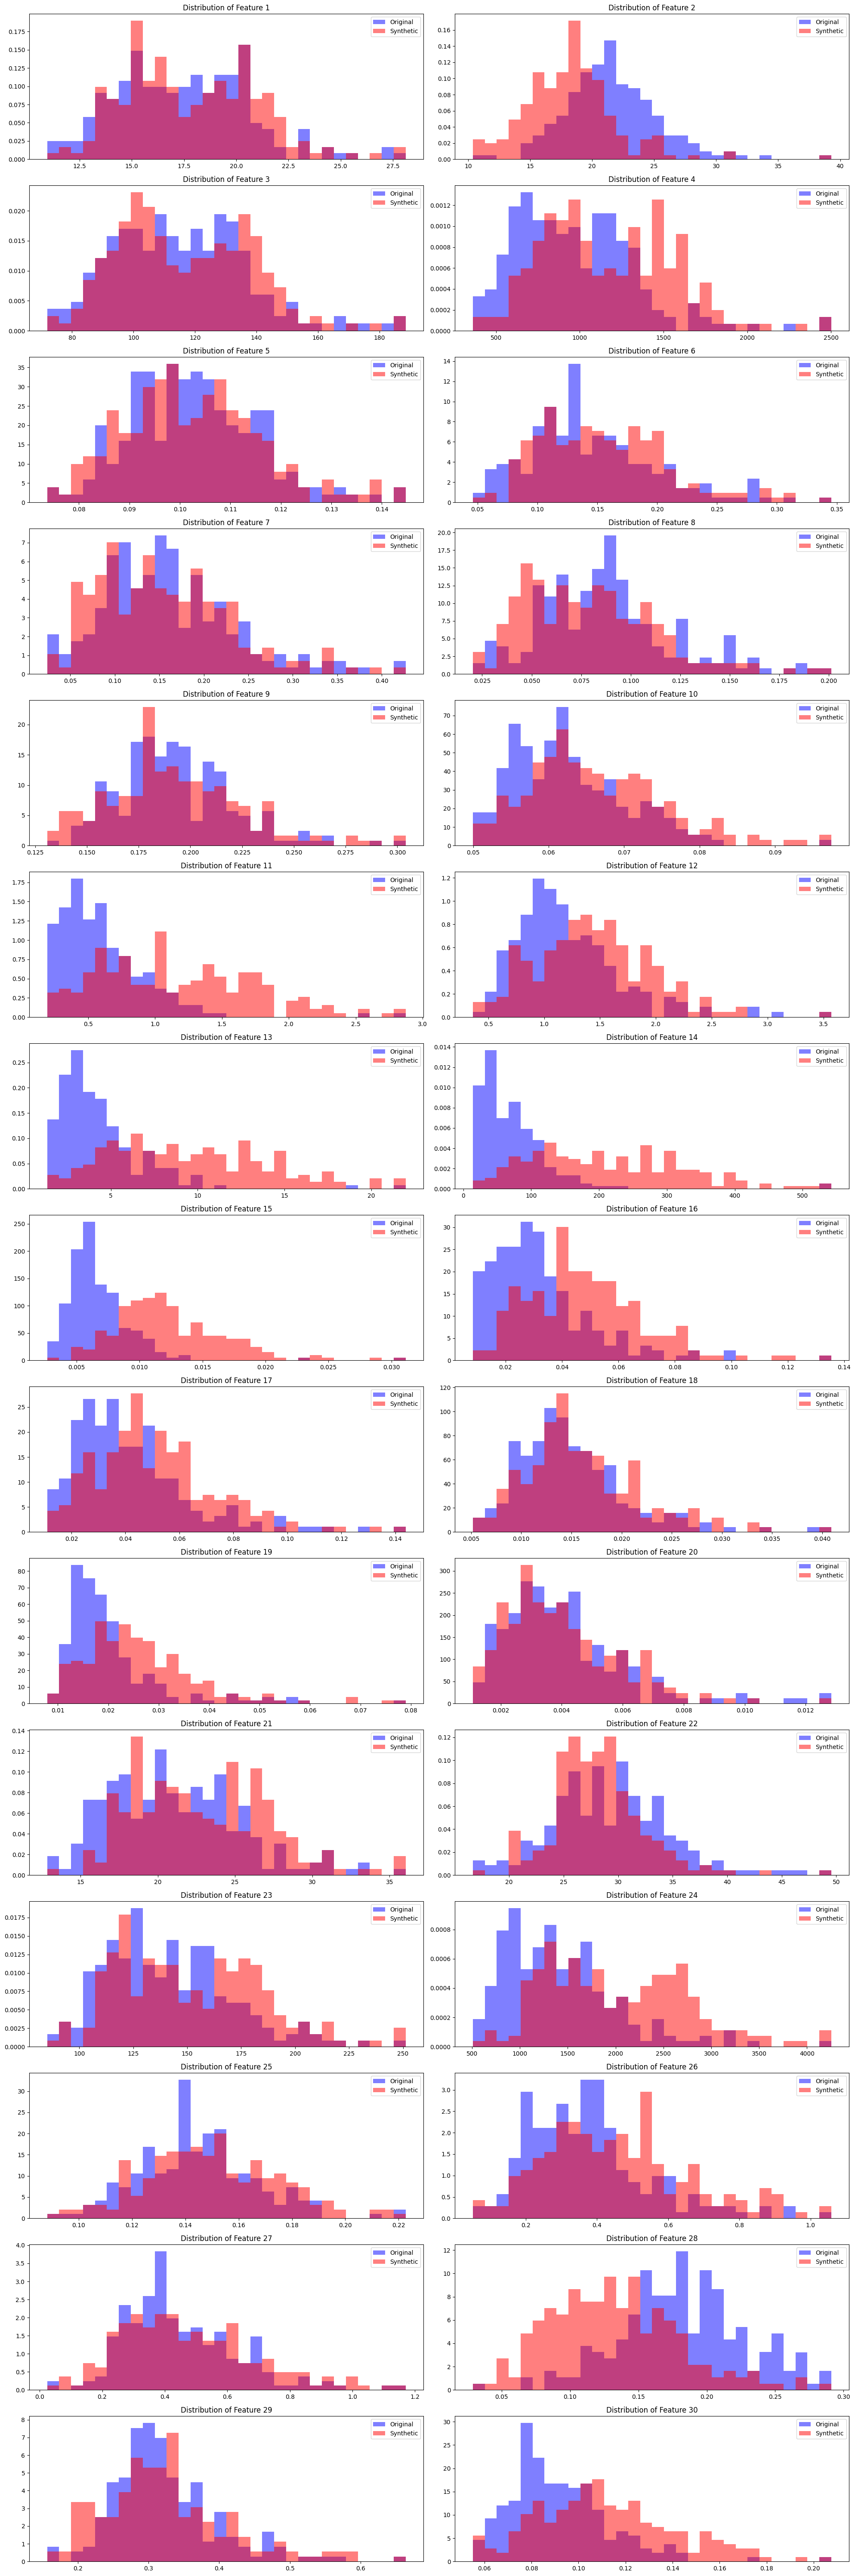

In [41]:
def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=30, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=30, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
X_minority_df = pd.DataFrame(X_minority)
X_minority_fake_df = pd.DataFrame(X_minority_fake_adjusted)
plot_feature_distributions(X_minority_df, X_minority_fake_df)

# Correlation adjustment using Cholesky Decomposition and Min_Max Scaling

In [6]:
#Generate Synthetic Data
X_minority = X[y==1]
X_minority_np = X_minority.to_numpy()
forest_model = ForestDiffusionModel(X_minority_np, label_y=None, n_t=50, duplicate_K=100,
                                     bin_indexes=[], cat_indexes=[], int_indexes=[],
                                     diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X_minority))

In [7]:
print(np.isnan(X).sum(), np.isinf(X).sum())
print(np.isnan(X_minority_fake).sum(), np.isinf(X_minority_fake).sum())

radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64 radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
s

In [8]:
correlation_matrix = pd.DataFrame(X).corr()
print("Correlation Matrix of Original Data:")
print(correlation_matrix)

Correlation Matrix of Original Data:
                         radius_mean  texture_mean  perimeter_mean  area_mean  \
radius_mean                 1.000000      0.323782        0.997855   0.987357   
texture_mean                0.323782      1.000000        0.329533   0.321086   
perimeter_mean              0.997855      0.329533        1.000000   0.986507   
area_mean                   0.987357      0.321086        0.986507   1.000000   
smoothness_mean             0.170581     -0.023389        0.207278   0.177028   
compactness_mean            0.506124      0.236702        0.556936   0.498502   
concavity_mean              0.676764      0.302418        0.716136   0.685983   
concave points_mean         0.822529      0.293464        0.850977   0.823269   
symmetry_mean               0.147741      0.071401        0.183027   0.151293   
fractal_dimension_mean     -0.311631     -0.076437       -0.261477  -0.283110   
radius_se                   0.679090      0.275869        0.691765   0.7

In [9]:
import numpy as np

# Step 1: Compute the covariance matrices
cov_minority = np.cov(X, rowvar=False)
cov_minority_fake = np.cov(X_minority_fake, rowvar=False)

# Step 2: Cholesky decomposition
# Ensure the covariance matrices are positive definite
epsilon = 1e-5
cov_minority += np.eye(cov_minority.shape[0]) * epsilon
cov_minority_fake += np.eye(cov_minority_fake.shape[0]) * epsilon

# Perform Cholesky decomposition on the original covariance matrix
L_minority = np.linalg.cholesky(cov_minority)

# Step 3: Standardize synthetic data
synthetic_mean = np.mean(X_minority_fake, axis=0)
synthetic_std = np.std(X_minority_fake, axis=0)
standardized_synthetic = (X_minority_fake - synthetic_mean) / synthetic_std

# Adjust the synthetic data to match the correlation of the original minority class
adjusted_synthetic = (L_minority @ standardized_synthetic.T).T

# Rescale the adjusted synthetic data
adjusted_synthetic = adjusted_synthetic * synthetic_std + synthetic_mean

# Step 4: Min-Max scaling to fit within the range of X_minority
min_original = np.min(X, axis=0)  # Min of each feature
max_original = np.max(X, axis=0)  # Max of each feature

# Perform min-max scaling for each feature
X_minority_fake_adjusted = np.zeros_like(adjusted_synthetic)  # Initialize scaled array

for i in range(adjusted_synthetic.shape[1]):  # Iterate over each feature
    min_adj = np.min(adjusted_synthetic[:, i])
    max_adj = np.max(adjusted_synthetic[:, i])
    
    # Apply min-max scaling for each feature individually
    X_minority_fake_adjusted[:, i] = min_original[i] + (adjusted_synthetic[:, i] - min_adj) * \
                                       (max_original[i] - min_original[i]) / (max_adj - min_adj)
    
    

pd.DataFrame(np.corrcoef(X, rowvar=False)).to_csv('Original Data Correlation.csv')
pd.DataFrame(np.corrcoef(X_minority_fake_adjusted, rowvar=False)).to_csv('Adjusted Synthetic Correlation (CD).csv')
print("Adjusted Synthetic Data (after min-max scaling):\n", X_minority_fake_adjusted)

pd.DataFrame(X_minority_fake_adjusted).to_csv('breast_cancer_generated_minority_FD_CM_CD.csv')


Adjusted Synthetic Data (after min-max scaling):
 [[1.93549809e+01 2.51946873e+01 1.27607135e+02 ... 1.41353002e-01
  3.87188507e-01 1.36673594e-01]
 [1.04369515e+01 2.04642140e+01 6.56689284e+01 ... 4.66076442e-02
  3.21123334e-01 1.23333099e-01]
 [9.92429354e+00 2.92909183e+01 6.36362021e+01 ... 7.85145851e-02
  3.48777099e-01 1.47683167e-01]
 ...
 [2.00893525e+01 2.01788656e+01 1.32271718e+02 ... 1.48004233e-01
  4.34266666e-01 1.25609594e-01]
 [1.44156082e+01 2.01238590e+01 9.32399961e+01 ... 6.15454534e-02
  2.68805086e-01 8.01921657e-02]
 [1.00415194e+01 1.35737368e+01 6.26011612e+01 ... 4.69698752e-02
  3.14454249e-01 1.05183164e-01]]


/tmp/ipykernel_30/129962225.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_minority_fake_adjusted[:, i] = min_original[i] + (adjusted_synthetic[:, i] - min_adj) * \
/tmp/ipykernel_30/129962225.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (max_original[i] - min_original[i]) / (max_adj - min_adj)


RandomForestClassifier

In [10]:
X_balanced = np.concatenate((X, X_minority_fake_adjusted), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake_adjusted.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

Class distribution after augmentation: {0.0: 357, 1.0: 424}


In [11]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")

Recall score (original data): 0.9062
Recall score (generated data): 0.9375
F1 score (original data): 0.9508
F1 score (generated data): 0.9677


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


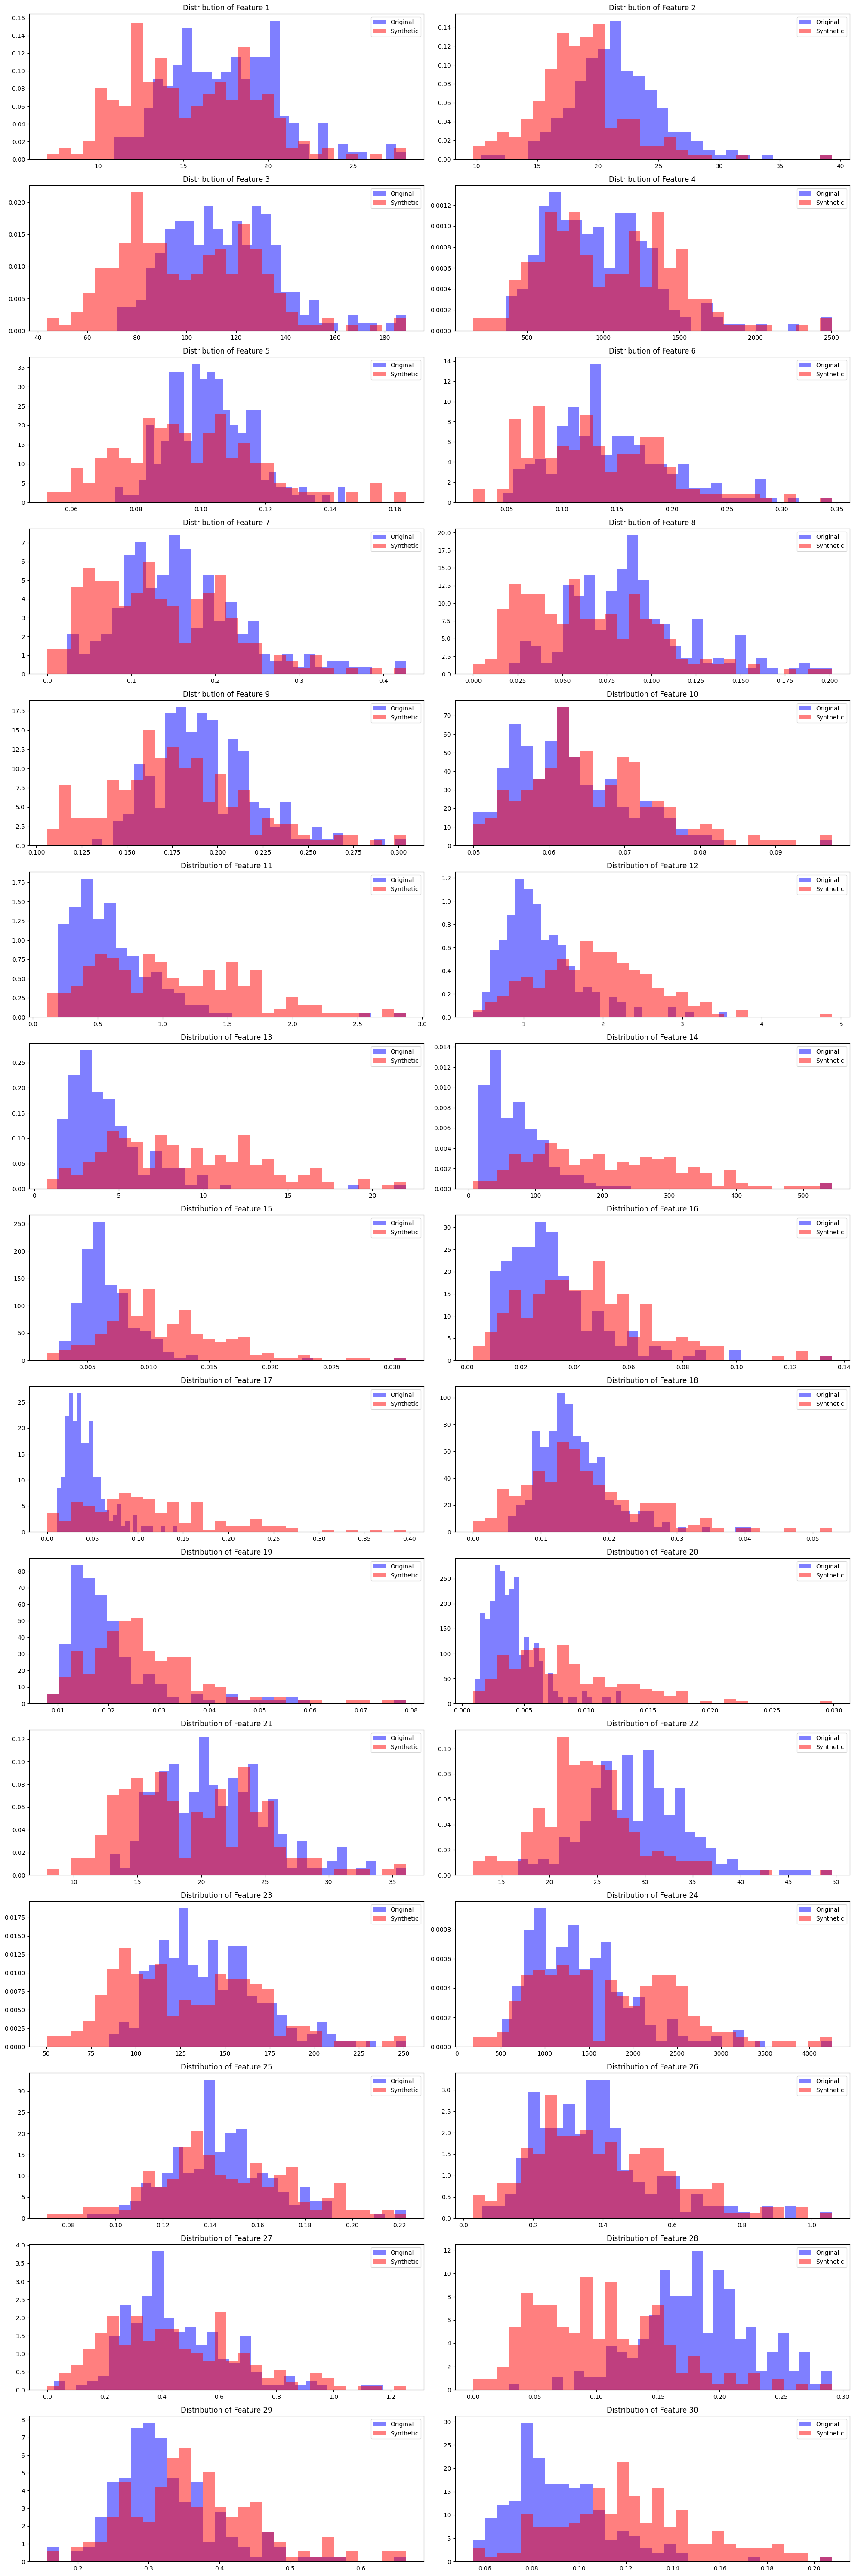

In [12]:
def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=30, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=30, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
X_minority_df = pd.DataFrame(X_minority)
X_minority_fake_df = pd.DataFrame(X_minority_fake_adjusted)
plot_feature_distributions(X_minority_df, X_minority_fake_df)

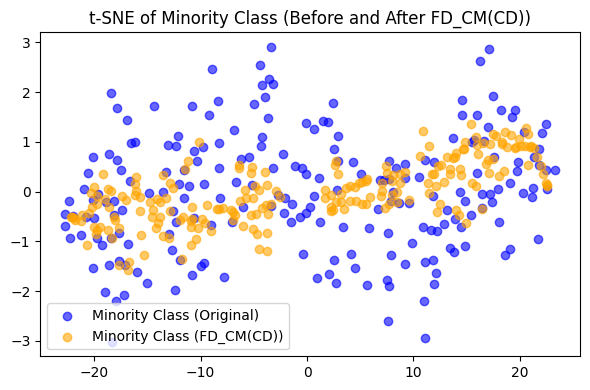

In [13]:
# Apply openTSNE for t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean",
    n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority)
X_tsne_res_minority = tsne.fit(X_minority_fake_adjusted)

# Create t-SNE Plot for minority class before and after SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for SMOTE-generated synthetic minority class data
ax.scatter(X_tsne_res_minority[:, 0], X_tsne_res_minority[:, 1], c='orange', label='Minority Class (FD_CM(CD))', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD_CM(CD))')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


RandomForestClassifier

In [16]:
from sklearn.metrics import classification_report, accuracy_score

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)



print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")
print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

Recall score (original data): 0.9062
Recall score (generated data): 0.9375
F1 score (original data): 0.9508
F1 score (generated data): 0.9677
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.94      0.97        64

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


GradientBoostingClassifier

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

clf_orig = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)



print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")
print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

Recall score (original data): 0.9062
Recall score (generated data): 0.9219
F1 score (original data): 0.9508
F1 score (generated data): 0.9440
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       107
           1       0.97      0.92      0.94        64

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


XGBoostClassifier

In [19]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

clf_orig = xgb.XGBClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = xgb.XGBClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)



print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")
print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

Recall score (original data): 0.9375
Recall score (generated data): 0.9375
F1 score (original data): 0.9677
F1 score (generated data): 0.9600
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.94      0.97        64

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       107
           1       0.98      0.94      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171

